Code from Lookalike task:

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
customers = pd.read_csv("/content/drive/MyDrive/Zeotap_Assignment_Ansh/Customers.csv")
products = pd.read_csv("/content/drive/MyDrive/Zeotap_Assignment_Ansh/Products.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Zeotap_Assignment_Ansh/Transactions.csv")

In [28]:
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

In [29]:
customer_transactions = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean")
).reset_index()

In [30]:
customer_data = pd.merge(customers, customer_transactions, on="CustomerID", how="left")

In [31]:
customer_data[["total_spent", "transaction_count", "avg_transaction_value"]] = customer_data[
    ["total_spent", "transaction_count", "avg_transaction_value"]
].fillna(0)

In [32]:
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

In [33]:
features = ["total_spent", "transaction_count", "avg_transaction_value"] + [col for col in customer_data.columns if "Region_" in col]
X = customer_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


1. Trying out K-Means with PCA:

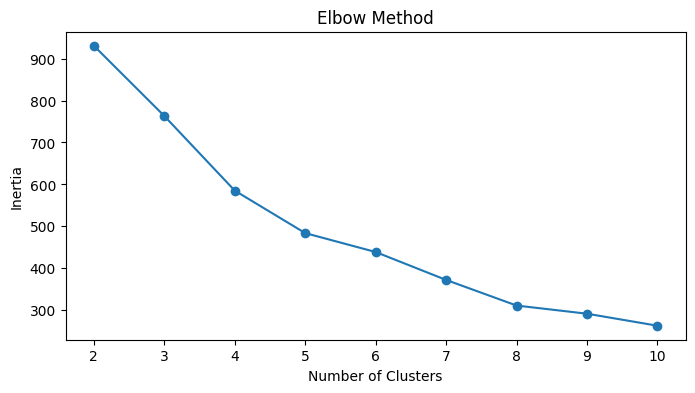

Davies-Bouldin Index: 1.1926430643192663
Silhouette Score: 0.31973356884457993


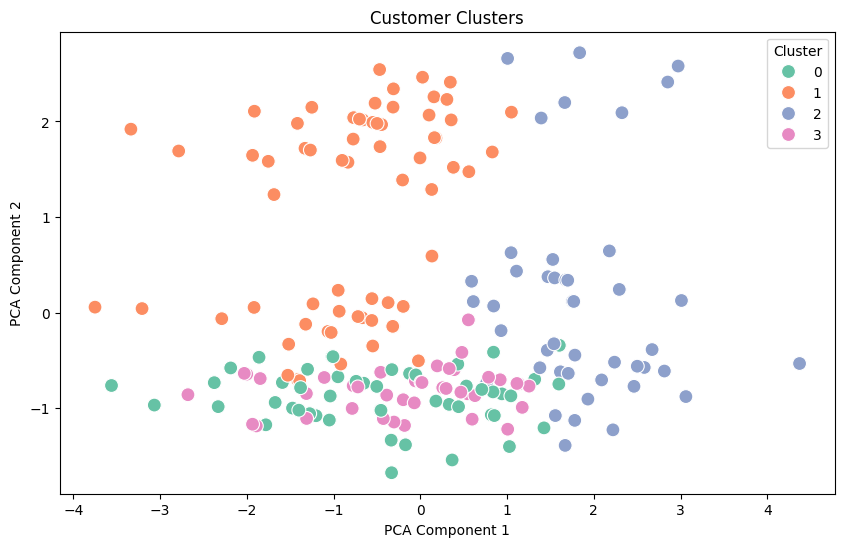

In [34]:
inertia = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Fit K-Means with the optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the customer data
customer_data["Cluster"] = labels

# Step 5: Evaluate Clustering
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X_scaled, labels)
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Step 6: Visualization
# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2", s=100)
plt.title("Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Save the clustered data
customer_data.to_csv("Clustered_Customers.csv", index=False)


2. Trying Out DBSCAN with PCA:

In [35]:
from sklearn.cluster import DBSCAN

Davies-Bouldin Index (DBSCAN): 1.3280719753042347


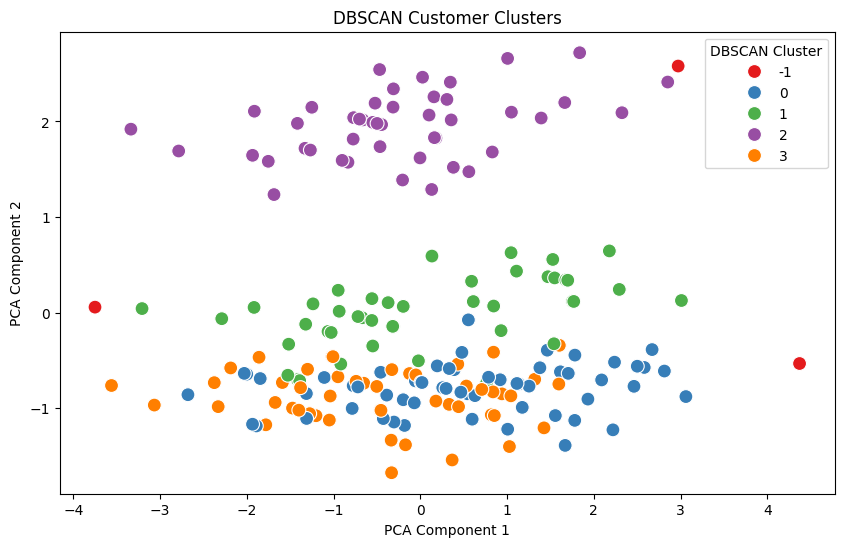

In [38]:
# Step 6: Clustering with DBSCAN
# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Add DBSCAN cluster labels to the customer data
customer_data["DBSCAN_Cluster"] = labels_dbscan

# Step 7: Evaluate DBSCAN Clustering
# Calculate Davies-Bouldin Index for DBSCAN (ignoring noise points labeled as -1)
valid_points = labels_dbscan != -1
if valid_points.sum() > 0:
    db_index_dbscan = davies_bouldin_score(X_scaled[valid_points], labels_dbscan[valid_points])
    print(f"Davies-Bouldin Index (DBSCAN): {db_index_dbscan}")
else:
    print("Davies-Bouldin Index (DBSCAN): Not applicable, all points are noise.")

# Step 8: Visualization
# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_dbscan, palette="Set1", s=100)
plt.title("DBSCAN Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="DBSCAN Cluster")
plt.show()

# Save the clustered data
customer_data.to_csv("Clustered_Customers.csv", index=False)


Adding new features to see if the result improves:

1. Recency of the customer

In [43]:
# Calculating recency for each customer
current_date = pd.Timestamp("2025-01-01")  # Replace with the current date
days_since_last_transaction = (current_date - customer_transactions["last_transaction_date"]).dt.days
customer_transactions["recency"] = days_since_last_transaction

Handling NaN values and filling with 0's to make it compatible with K-Means and DBSCAN reqirements for calculations:

In [44]:
# Merging with customer profile data
customer_data = pd.merge(customers, customer_transactions, on="CustomerID", how="left")

# Filling NaN values (e.g., customers without transactions)
customer_data[["total_spent", "transaction_count", "avg_transaction_value", "recency"]] = customer_data[
    ["total_spent", "transaction_count", "avg_transaction_value", "recency"]
].fillna(0)

2. Customer lifetime

In [45]:
# Adding customer lifetime feature
customer_data["customer_lifetime"] = (current_date - customer_data["SignupDate"]).dt.days

# Encoding categorical features (e.g., Region)
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

In [46]:
# Step 3: Feature Selection and Scaling
features = [
    "total_spent", "transaction_count", "avg_transaction_value", "recency", "customer_lifetime"
] + [col for col in customer_data.columns if "Region_" in col]
X = customer_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Trying Out all 3: K-Means, DBSCAN and Gaussian Mixture Models (GMM):

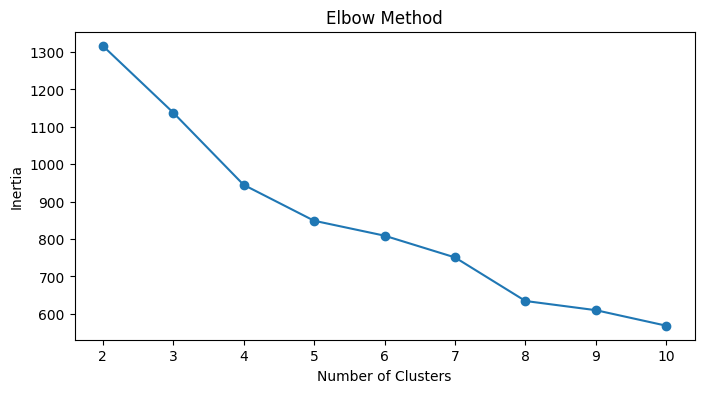

Davies-Bouldin Index (K-Means): 1.3598252682165464
Silhouette Score (K-Means): 0.2280843622519346


In [59]:
# Step 4: Clustering with K-Means
# Determine optimal number of clusters using the elbow method
inertia = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Fit K-Means with the optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=9, init='k-means++', random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Add K-Means cluster labels to the customer data
customer_data["KMeans_Cluster"] = labels_kmeans

# Step 5: Evaluate K-Means Clustering
# Calculate Davies-Bouldin Index for K-Means
db_index_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)
print(f"Davies-Bouldin Index (K-Means): {db_index_kmeans}")

# Calculate Silhouette Score for K-Means
silhouette_avg_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f"Silhouette Score (K-Means): {silhouette_avg_kmeans}")

In [62]:
# Step 6: Clustering with DBSCAN
# Fit DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5)  # Adjusted parameters
labels_dbscan = dbscan.fit_predict(X_scaled)

# Add DBSCAN cluster labels to the customer data
customer_data["DBSCAN_Cluster"] = labels_dbscan

# Step 7: Evaluate DBSCAN Clustering
# Calculate Davies-Bouldin Index for DBSCAN (ignoring noise points labeled as -1)
valid_points = labels_dbscan != -1
if valid_points.sum() > 0:
    db_index_dbscan = davies_bouldin_score(X_scaled[valid_points], labels_dbscan[valid_points])
    print(f"Davies-Bouldin Index (DBSCAN): {db_index_dbscan}")

    # Calculate Silhouette Score for DBSCAN
    silhouette_avg_dbscan = silhouette_score(X_scaled[valid_points], labels_dbscan[valid_points])
    print(f"Silhouette Score (DBSCAN): {silhouette_avg_dbscan}")
else:
    print("Davies-Bouldin Index (DBSCAN): Not applicable, all points are noise.")
    print("Silhouette Score (DBSCAN): Not applicable, all points are noise.")


Davies-Bouldin Index (DBSCAN): 0.9257393236490291
Silhouette Score (DBSCAN): 0.2897203846542125


In [63]:
# Step 8: Clustering with Gaussian Mixture Models (GMM)
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)

# Add GMM cluster labels to the customer data
customer_data["GMM_Cluster"] = labels_gmm

# Evaluate GMM Clustering
db_index_gmm = davies_bouldin_score(X_scaled, labels_gmm)
print(f"Davies-Bouldin Index (GMM): {db_index_gmm}")
silhouette_avg_gmm = silhouette_score(X_scaled, labels_gmm)
print(f"Silhouette Score (GMM): {silhouette_avg_gmm}")

Davies-Bouldin Index (GMM): 1.599274465242995
Silhouette Score (GMM): 0.22220597731455718


Best Clustering was observed in DBSCAN. (Davies-Bouldin Index (DBSCAN): 0.9257393236490291)

Best visualization and clustering (considering both (Davies-Bouldin Index and Silhouette Score) was seen in DBSCAN using T-SNE with 2 features.

Davies-Bouldin Index (K-Means): 1.5547470583636085
Silhouette Score (K-Means): 0.232417283419193
Davies-Bouldin Index (DBSCAN): 1.48516948434156
Silhouette Score (DBSCAN): 0.29302331815607724


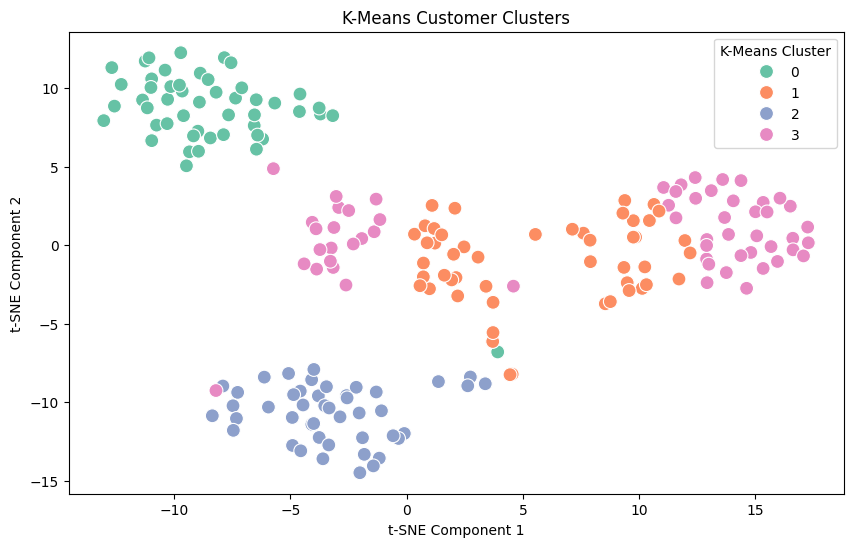

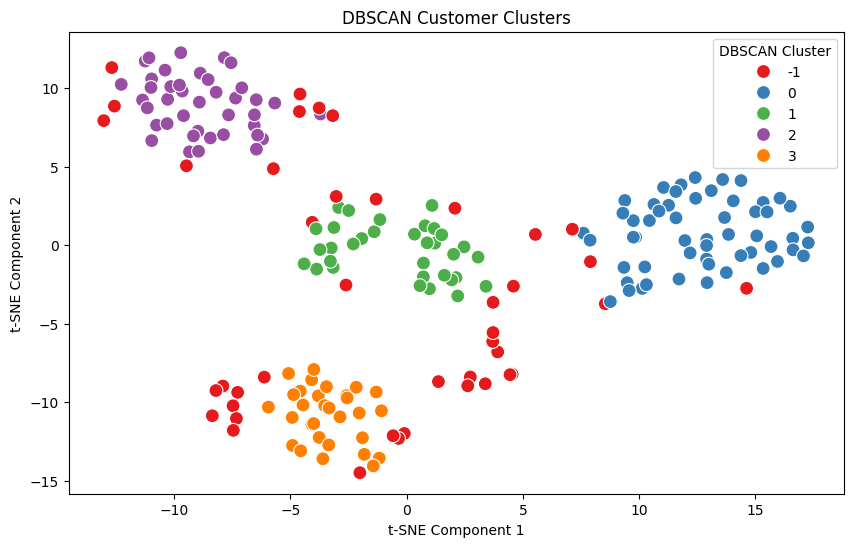

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data
# customers = pd.read_csv("Customers.csv")
# products = pd.read_csv("Products.csv")
# transactions = pd.read_csv("Transactions.csv")

# Step 2: Data Preprocessing
# Convert date columns to datetime format
customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

# Aggregate transactional data for each customer
customer_transactions = transactions.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    transaction_count=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    last_transaction_date=("TransactionDate", "max")
).reset_index()

# Calculate recency for each customer
current_date = pd.Timestamp("2025-01-01")  # Replace with the current date
days_since_last_transaction = (current_date - customer_transactions["last_transaction_date"]).dt.days
customer_transactions["recency"] = days_since_last_transaction

# Merge with customer profile data
customer_data = pd.merge(customers, customer_transactions, on="CustomerID", how="left")

# Fill NaN values (e.g., customers without transactions)
customer_data[["total_spent", "transaction_count", "avg_transaction_value", "recency"]] = customer_data[
    ["total_spent", "transaction_count", "avg_transaction_value", "recency"]
].fillna(0)

# Add customer lifetime feature
customer_data["customer_lifetime"] = (current_date - customer_data["SignupDate"]).dt.days

# Encode categorical features (e.g., Region)
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

# Step 3: Feature Selection and Scaling
features = [
    "total_spent", "transaction_count", "avg_transaction_value", "recency", "customer_lifetime"
] + [col for col in customer_data.columns if "Region_" in col]
X = customer_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Clustering with K-Means
# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add K-Means cluster labels to the customer data
customer_data["KMeans_Cluster"] = kmeans_labels

# Step 5: Evaluate K-Means Clustering
kmeans_db_index = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_silhouette_score = silhouette_score(X_scaled, kmeans_labels)
print(f"Davies-Bouldin Index (K-Means): {kmeans_db_index}")
print(f"Silhouette Score (K-Means): {kmeans_silhouette_score}")

# Step 6: Clustering with DBSCAN
# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Add DBSCAN cluster labels to the customer data
customer_data["DBSCAN_Cluster"] = labels_dbscan

# Step 7: Evaluate DBSCAN Clustering
# Calculate Davies-Bouldin Index for DBSCAN (ignoring noise points labeled as -1)
valid_points = labels_dbscan != -1
if valid_points.sum() > 0:
    db_index_dbscan = davies_bouldin_score(X_scaled[valid_points], labels_dbscan[valid_points])
    dbscan_silhouette_score = silhouette_score(X_scaled[valid_points], labels_dbscan[valid_points])
    print(f"Davies-Bouldin Index (DBSCAN): {db_index_dbscan}")
    print(f"Silhouette Score (DBSCAN): {dbscan_silhouette_score}")
else:
    print("Davies-Bouldin Index (DBSCAN): Not applicable, all points are noise.")

# Step 8: Visualization for K-Means
# Reduce dimensions for visualization using t-SNE
tsne_kmeans = TSNE(n_components=2, random_state=42)
X_tsne_kmeans = tsne_kmeans.fit_transform(X_scaled)

# Visualize K-Means clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne_kmeans[:, 0], y=X_tsne_kmeans[:, 1], hue=kmeans_labels, palette="Set2", s=100)
plt.title("K-Means Customer Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="K-Means Cluster")
plt.show()

# Step 9: Visualization for DBSCAN
# Reduce dimensions for visualization using t-SNE
tsne_dbscan = TSNE(n_components=2, random_state=42)
X_tsne_dbscan = tsne_dbscan.fit_transform(X_scaled)

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne_dbscan[:, 0], y=X_tsne_dbscan[:, 1], hue=labels_dbscan, palette="Set1", s=100)
plt.title("DBSCAN Customer Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="DBSCAN Cluster")
plt.show()

# Save the clustered data
customer_data.to_csv("Clustered_Customers.csv", index=False)
